# Assignment 1

Imports and Packages

In [ ]:
import numpy as np
import pandas as pd
import time
import functools
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

Load Data

In [ ]:
# Data loading function.
def dataloading(batch_size=32, mean=tf.constant([0.4914, 0.4822, 0.4465]), std=tf.constant([0.2023, 0.1994, 0.2010])):
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

    # apply normalization
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Reserve 10,000 samples for validation.
    x_val = x_train[-10000:]
    y_val = y_train[-10000:]
    x_train = x_train[:-10000]
    y_train = y_train[:-10000]

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    for loader in [train_dataset, val_dataset, test_dataset]:
        loader.mean, loader.std = mean, std
        loader.data_max = tf.reshape((1. - mean) / std, (1, 1, 1, -1))
        loader.data_min = tf.reshape((0. - mean) / std, (1, 1, 1, -1))

    return train_dataset, val_dataset, test_dataset

# Load CIFAR-10 dataset with batch size = 128
train_dataset, val_dataset, test_dataset = dataloading(batch_size=128)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Part 1: CIFAR10 CNN

This task evaluates the effect of different optimization algorithms on training a CNN for CIFAR10 image classification. The average training loss per epoch is
compared to assess the convergence speed, stability, and overall optimization performance of each algorithm.

In [ ]:
# List of optimizers to be compared, all with learning rate = 0.001
optimizer_names = ['SGD', 'Adagrad', 'RMSprop', 'Nesterov','Adam']
optimizer_list = [tf.keras.optimizers.SGD(learning_rate=0.001),
                  tf.keras.optimizers.Adagrad(learning_rate=0.001),
                  tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,nesterov=True),
                  tf.keras.optimizers.Adam(learning_rate=0.001)]

**Note:** A momentum of 0.9 is commonly used because it helps speed up convergence and smooth out noisy gradients. Lower values may result in slower convergence, while higher values could cause the step size to become too large and potentially overshoot the minimum of the loss function.

In [ ]:
# Function to construct and compile the CNN model.
def build_compile(optimizer_name='SGD', drop_out=0):

    """
    Builds and compiles a CNN with 3 convolutional blocks and a fully connected layer.
    Each block: 5x5 convolutional filters (stride 1, ReLU activation function)
                2x2 MaxPool units (stride 2)
                Dropout

    optimizer_name: optimizer for compilation
    drop_out: dropout rate (0 = no dropout)
    """

    # Define model
    model = tf.keras.Sequential([

    # Block 1
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(drop_out),

    # Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(drop_out),

    # Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(drop_out),

    # Fully connected layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

    # Compile model
    model.compile(optimizer=optimizer_name, loss=keras.losses.SparseCategoricalCrossentropy())

    # Summary of your model
    model.summary()
    return model

### Model Evaluation Without Dropout

In [ ]:
# Array to store training performance
hist_loss_nn = []

# Iterate over optimizers and train the network
for item, name in zip(optimizer_list, optimizer_names):
    print("-----------------------------")
    print("Doing %s optimizer" %str(name))
    print("-----------------------------")

    # Build a model for each optimizer
    model = build_compile(optimizer_name=item, drop_out=0)

    # Train the model
    history = model.fit(train_dataset, epochs=100)

    # Store the performance for plotting and comparison
    hist_loss_nn.append(history.history['loss'])

-----------------------------
Doing SGD optimizer
-----------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 2.2824
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.1677
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.0316
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.9291
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.8581
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7987
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7431
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6897
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6388
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5945
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.5556
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.5201
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4881
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4586
Epoch 15/100
313/313 ━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.2038
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.8778
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7194
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5941
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5049
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.4457
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3987
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3626
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3282
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3039
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2781
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2560
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2327
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2123
Epoch 15/100
313/313 ━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.0223
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1845
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8843
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6935
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5176
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3558
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2354
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1756
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1457
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1182
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1184
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0978
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0940
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0848
Epoch 15/100
313/313 ━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.0933
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5473
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3723
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2486
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.1521
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0658
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9962
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9283
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8805
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8280
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7825
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7411
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7053
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6666
Epoch 15/100
313/313 ━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.6569
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0371
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8165
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6517
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3584
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2409
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1839
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1368
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1211
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1181
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1056
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1133
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0966
Epoch 15/100
313/313 ━━━━━━━━

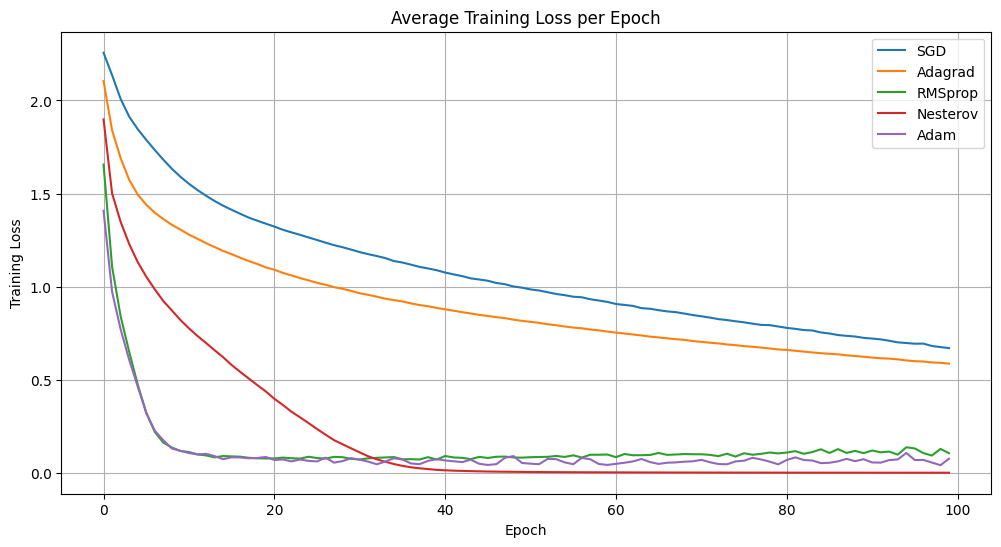

In [ ]:
# Plot the average training loss per epoch for each optimizer
plt.figure(figsize=(12,6))

# Plot loss curve for each optimizer
for i in range(len(hist_loss_nn)):
    plt.plot(hist_loss_nn[i], label=optimizer_names[i])

plt.title('Average Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

**Discussion**

From the plot above, it is clear that Adam and RMSprop exhibit the fastest convergence, with the training loss decreasing sharply within the first 5-10 epochs and stabilising at a value close to zero. This is expected as both optimizers use adaptive learning rates that automatically adjust the step size for each parameter based on past gradients. This enables efficient and accelerated learning, particularly in the early stages of training. In later epochs, Adam and RMSprop display minor oscillations in the loss curve. These fluctuations reflect the typical stochastic behaviour that comes with using mini-batch gradient decent, where gradient estimates are computed from mini-batches of data and therefore contain sampling noise. These variations are not signals of instability or overfitting, as the training loss remains consistently low throughout later stages of training. Overall, both optimizers demonstrate fast and stable convergence, with very similar performances.

Nesterov momentum improves convergence by incorporating a look-ahead gradient update, which explains its smoother and faster descent compared to standard SGD. Although it does not converge as quickly as Adam and RMSprop in the early epochs, it achieves the lowest final training loss. The loss is approximately zero, indicating that the model predicts almost perfectly on the training data. However, this near-perfect training does not necessarily imply better overall performance. Instead, it suggests that the network may have memorized the training dataset, resulting in overfitting rather than improved generalization. Since this plot only shows training performance, the model can be further evaluated by introducing dropout, which is a regularization technique used to reduce overfitting. This evaluation is presented below.

AdaGrad and SGD exhibit the slowest convergence among the optimizers, with training loss decreasing steadily but gradually as the network trains. Even after 100 epochs, their loss values remain substantially higher than those achieved by the other methods. In particular, SGD demonstrates the weakest optimization performance, converging slowly and finishing with a training loss of approximately 0.7. This behaviour is expected, as SGD uses a fixed learning rate which limits its ability to make progress during training. AdaGrad performs better than SGD during the early stages of training, showing a faster initial decrease in training loss. However, its rate of improvement diminishes over time because AdaGrad continuously shrinks the learning rate, leading to progressively slower convergence.

In conclusion, the adaptive optimizers, Adam and RMSprop, significantly outperform the non-adaptive ones, SGD and AdaGrad, and Nesterov momentum offers a good middle ground.


### Model Evaluation With Dropout

In [ ]:
# List of optimizers to be compared, all with learning rate = 0.001
optimizer_names = ['SGD', 'Adagrad', 'RMSprop', 'Nesterov','Adam']
optimizer_list = [tf.keras.optimizers.SGD(learning_rate=0.001),
                  tf.keras.optimizers.Adagrad(learning_rate=0.001),
                  tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,nesterov=True),
                  tf.keras.optimizers.Adam(learning_rate=0.001)]

In [ ]:
# Array to store training performance
hist_loss_nn = []

# Iterate over optimizers and train the network
for item, name in zip(optimizer_list, optimizer_names):
    print("-----------------------------")
    print("Doing %s optimizer" %str(name))
    print("-----------------------------")

    # Build a model for each optimizer, with dropout
    model = build_compile(optimizer_name=item, drop_out=0.25)

    # Train the model
    history = model.fit(train_dataset, epochs=100)

    # Store the performance for plotting and comparison
    hist_loss_nn.append(history.history['loss'])

-----------------------------
Doing SGD optimizer
-----------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 2.3127
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.1939
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.0896
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.0121
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.9597
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.9167
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.8766
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.8317
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7898
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7562
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.7206
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6910
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6627
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.6300
Epoch 15/100
313/313 ━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 2.2369
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.9791
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.8691
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.7699
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6950
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.6390
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5919
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5549
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5246
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5022
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4799
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4597
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.4425
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.4225
Epoch 15/100
313/313 ━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.9851
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.3169
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0940
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9460
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8401
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7519
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6836
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6162
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5621
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5196
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4843
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.4389
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4212
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3917
Epoch 15/100
313/313 ━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 2.1443
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.7420
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.5439
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4426
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.3604
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.2961
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.2349
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.1742
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1307
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0926
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0586
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0337
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0004
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9777
Epoch 15/100
313/313 ━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 1.9005
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2777
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1013
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9863
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9003
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8337
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7597
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7059
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6645
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6108
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5797
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5504
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4997
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4787
Epoch 15/100
313/313 ━━━━━━━

**Note:** A dropout rate of 0.25 was chosen as it is large enough to provide regularization but not significantly affect the model’s ability to learn. A higher value would provide stronger regularization but poses the risk of underfitting.

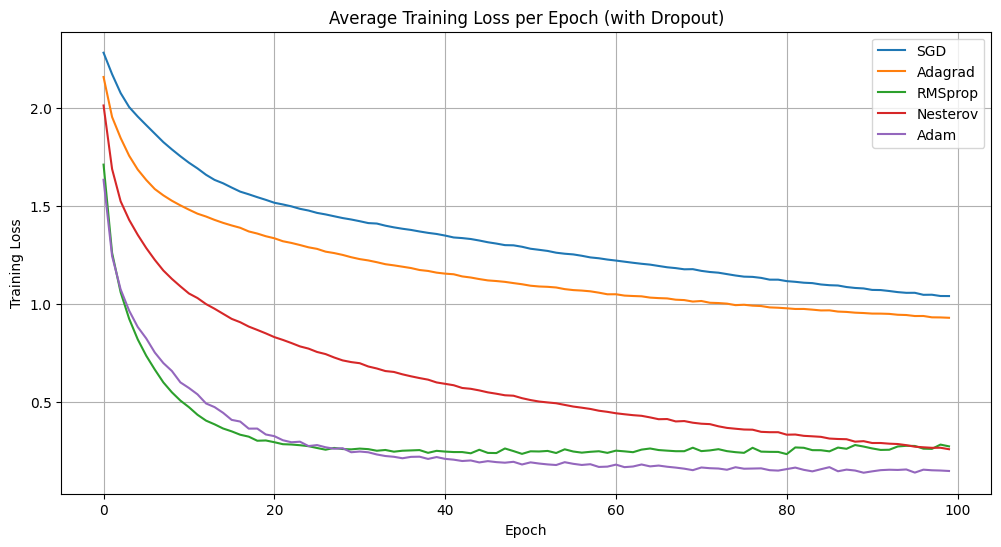

In [ ]:
# Plot the average training loss per epoch for each optimizer
plt.figure(figsize=(12,6))

# Plot loss curve for each optimizer
for i in range(len(hist_loss_nn)):
    plt.plot(hist_loss_nn[i], label=optimizer_names[i])

plt.title('Average Training Loss per Epoch (with Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

**Discussion of Models with Dropout**

With dropout, the training loss is higher across all optimizers. This is because dropout randomly deactivates neurons during training, preventing neurons from co-adapting too much. Most notably, Nesterov no longer achieves near-zero loss, with the training loss stabilising around 0.25 instead. Although the training loss is higher, the models are likely to exhibit improved generalization to unseen data, highlighting the trade-off between minimizing training loss and better generalization performance.

The relative convergence speed of the optimizers remains the same with the introduction of dropout. Adam and RMSprop still exhibit the fastest convergence, followed by Nesterov, while AdaGrad and SGD demonstrate comparatively slower optimization. This shows that the relative performance of the optimizers is consistent regardless of the 25% dropout rate. Once again, Adam and RMSprop display very similar convergence behaviour. In this case, however, RMSprop shows a slightly steeper decline during the initial epochs, while Adam demonstrates a more stable convergence in later epochs and achieves the lowest final training loss among all optimizers. Therefore, it is reasonable to conclude that Adam has the best training optimization performance.










# Part 2: CIFAR10 Image Classification

This task aims to design and improve a CNN architecture for CIFAR10 image classification to achieve a high test accuracy. Performance is evaluated using average loss, top-1 and top-5 error rates on the training and test datasets.

### Model 1: Baseline CNN

This baseline model uses the same CNN architecture from Part 1. Following the discussion above, dropout is added after the convolutional layers to reduce overfitting and the Adam optimizer is used as it showed the best training performance.

In [ ]:
# Define model
model_l1 = tf.keras.Sequential([

# Block 1
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 2
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 3
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Fully connected layer
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')])

# Compile model
top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_accuracy")   # Top-5 error rate
model_l1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy', top5])

# Summary of your model
model_l1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371,266 (9.05 MB)

 Trainable params: 2,371,266 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Model 1
history_l1 = model_l1.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=1)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.3268 - loss: 1.8395 - top5_accuracy: 0.8142 - val_accuracy: 0.5500 - val_loss: 1.2756 - val_top5_accuracy: 0.9518
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5499 - loss: 1.2622 - top5_accuracy: 0.9492 - val_accuracy: 0.6253 - val_loss: 1.0558 - val_top5_accuracy: 0.9669
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6265 - loss: 1.0521 - top5_accuracy: 0.9647 - val_accuracy: 0.6479 - val_loss: 0.9932 - val_top5_accuracy: 0.9725
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6630 - loss: 0.9528 - top5_accuracy: 0.9701 - val_accuracy: 0.7025 - val_loss: 0.8428 - val_top5_accuracy: 0.9774
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6971 - loss: 0.8557 - top5_accuracy: 0.9804 - val_accuracy: 0.7116 - val_loss: 0.8343 - val_top5_accuracy: 0.9783
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7262 - loss: 0.7763 -

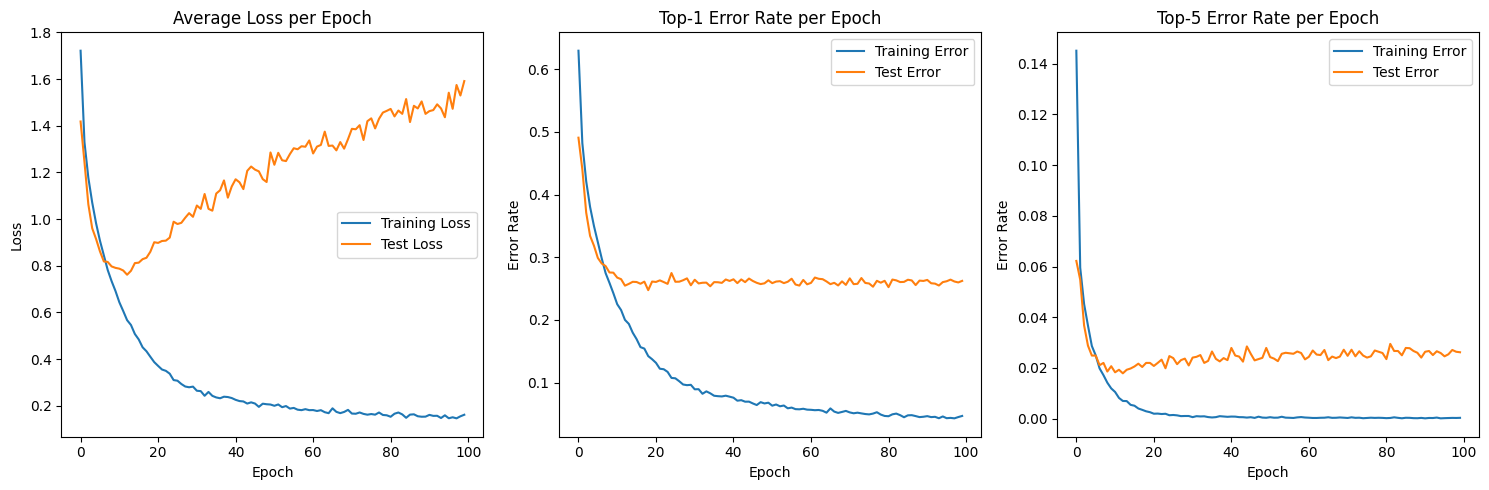

In [ ]:
# Plots
plt.figure(figsize=(15, 5))

# Plot average loss
plt.subplot(1, 3, 1)
plt.plot(history_l1.history['loss'], label='Training Loss')
plt.plot(history_l1.history['val_loss'],label='Test Loss')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot top-1 error rate
plt.subplot(1, 3, 2)
plt.plot(1 - np.array(history_l1.history['accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l1.history['val_accuracy']), label='Test Error')
plt.title('Top-1 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

# Plot top-5 error rate
plt.subplot(1, 3, 3)
plt.plot(1 - np.array(history_l1.history['top5_accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l1.history['val_top5_accuracy']), label='Test Error')
plt.title('Top-5 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.tight_layout()
plt.show()

The first plot shows that the training loss decreases steadily, reaching around 0.15. This indicates smooth and stable convergence and that the model can sufficiently fit the training data well. The test loss initially decreases in the very early stages of training, but then starts increasing after 10 epochs, ending above 1.5. The growing gap between training and test loss is a clear sign of overfitting and so it clear that the model continues improving on training data but generalization worsens.

The top-1 training error decreases to around 0.05, while the test error rate plateaus around 0.25. The top-5 training error also decreases to a near-zero value, but the test error stablizes near 0.02 and slightly increases in later epochs. In both error plots, the gap between training and test error widens significantly as training continues, confirming the existence of overfitting.

Despite the inclusion of dropout after each convolutional layer, the regularization is insufficient to prevent overfitting. This suggests that additional regularization strategies may be necessary to improve generalization performance.

### Model 2: Further Regularization

To address the severe overfitting, Model 2 builds on the baseline CNN by adding dropout after the dense layer. As this layer contains the most parameters in the network, it is the most prone to overfitting. A higher dropout rate of 0.5 is used to provide stronger regularization and reduce memorization of the training set. Batch normalization is also employed after each convolutional layer. This should stabilize training, allow for faster convergence and improve optimization performance. These changes should reduce the overfitting observed in Model 1.




In [ ]:
# Define model
model_l2 = tf.keras.Sequential([

# Block 1
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 2
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 3
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Fully connected layer
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])

# Compile model
top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_accuracy")
model_l2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy', top5])

# Summary of your model
model_l2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,372,290 (9.05 MB)

 Trainable params: 2,371,778 (9.05 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Train Model 2
history_l2 = model_l2.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=1)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.3475 - loss: 2.2936 - top5_accuracy: 0.8390 - val_accuracy: 0.3695 - val_loss: 2.9004 - val_top5_accuracy: 0.8859
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5326 - loss: 1.3059 - top5_accuracy: 0.9416 - val_accuracy: 0.6365 - val_loss: 1.0459 - val_top5_accuracy: 0.9653
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6052 - loss: 1.1115 - top5_accuracy: 0.9609 - val_accuracy: 0.6710 - val_loss: 0.9403 - val_top5_accuracy: 0.9733
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6560 - loss: 0.9844 - top5_accuracy: 0.9686 - val_accuracy: 0.7186 - val_loss: 0.8091 - val_top5_accuracy: 0.9785
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6893 - loss: 0.8782 - top5_accuracy: 0.9749 - val_accuracy: 0.7266 - val_loss: 0.7932 - val_top5_accuracy: 0.9786
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7168 - loss: 0.8032 -

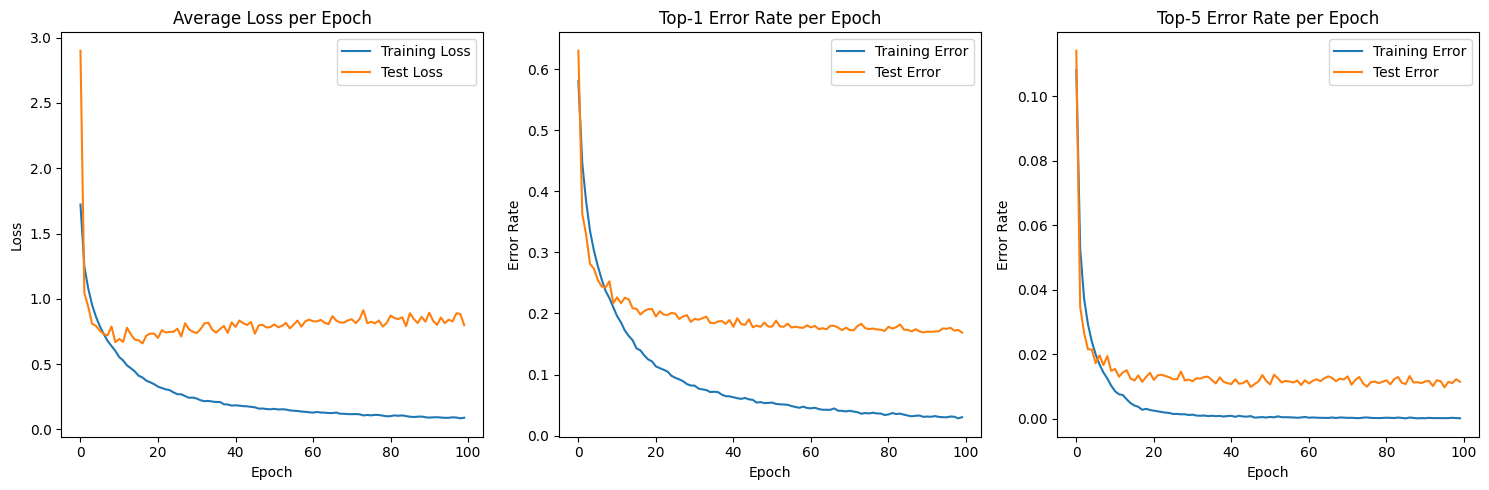

In [ ]:
# Plots
plt.figure(figsize=(15, 5))

# Plot average loss
plt.subplot(1, 3, 1)
plt.plot(history_l2.history['loss'], label='Training Loss')
plt.plot(history_l2.history['val_loss'],label='Test Loss')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot top-1 error rate
plt.subplot(1, 3, 2)
plt.plot(1 - np.array(history_l2.history['accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l2.history['val_accuracy']), label='Test Error')
plt.title('Top-1 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

# Plot top-5 error rate
plt.subplot(1, 3, 3)
plt.plot(1 - np.array(history_l2.history['top5_accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l2.history['val_top5_accuracy']), label='Test Error')
plt.title('Top-5 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.tight_layout()
plt.show()

Compared to Model 1, the test loss is now more stable, and although it still increases after the early epochs, the increase is much smaller. It stabilizes around 0.8 instead of rising toward 1.5. This suggests that batch normalization has successfully reduced overfitting. The gap between training and test is smaller but still present, suggesting that some overfitting still remains.

The top-1 test error stablises around 0.18, which is an improvement from Model 1's 0.25. The top-5 test error is around 0.015 and again better than Model 1. This indicates improved classification performance on unseen data.

The training loss and error convergence remain stable and efficient across all three plots, demonstrating that the addition of batch normalization and dropout after the dense layer does not negatively impact optimization, despite the increased regularization.


### Model 3: Addition of Data Augmentation

Model 3 introduces data augmentation in an attempt to further reduce overfitting and close the gap between training and test performance. CIFAR10 contains objects that appear in different positions and orientations. The model can train a wider range of variations of the same data by including different orientations, positions and spatial layouts of the original images. This makes it harder for the model to memorise specific features and therefore improves generalization. Random horizontal flips are applied so that the semantics of the images are preserved, just with objects appearing facing left or right. Vertical flips are not applied as they would distort the natural appearance of the objects, which would harm model learning. Random translations are also applied, adjusting the image size by up to 10%. This parameter value is a suitable choice as it is small enough to keep the objects visible, while large enough to prevent the model from relying on fixed image positions.


In [ ]:
# Define model
model_l3 = tf.keras.Sequential([
tf.keras.layers.Input(shape=(32,32,3)),
tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomTranslation(0.1, 0.1),  # Data augumentation

# Block 1
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 2
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Block 3
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),

# Fully connected layer
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])

# Compile model
top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_accuracy")
model_l3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy', top5])

# Summary of your model
model_l3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1000)           │     2,049,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,372,290 (9.05 MB)

 Trainable params: 2,371,778 (9.05 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Train Model 3
history_l3 = model_l3.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=1)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.3177 - loss: 2.3214 - top5_accuracy: 0.8183 - val_accuracy: 0.4634 - val_loss: 2.0641 - val_top5_accuracy: 0.9307
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4912 - loss: 1.4031 - top5_accuracy: 0.9302 - val_accuracy: 0.5849 - val_loss: 1.1966 - val_top5_accuracy: 0.9582
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5521 - loss: 1.2460 - top5_accuracy: 0.9487 - val_accuracy: 0.6591 - val_loss: 0.9801 - val_top5_accuracy: 0.9692
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5983 - loss: 1.1293 - top5_accuracy: 0.9549 - val_accuracy: 0.6847 - val_loss: 0.8993 - val_top5_accuracy: 0.9757
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6363 - loss: 1.0415 - top5_accuracy: 0.9637 - val_accuracy: 0.6782 - val_loss: 0.9358 - val_top5_accuracy: 0.9737
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6596 - loss: 0.9777 -

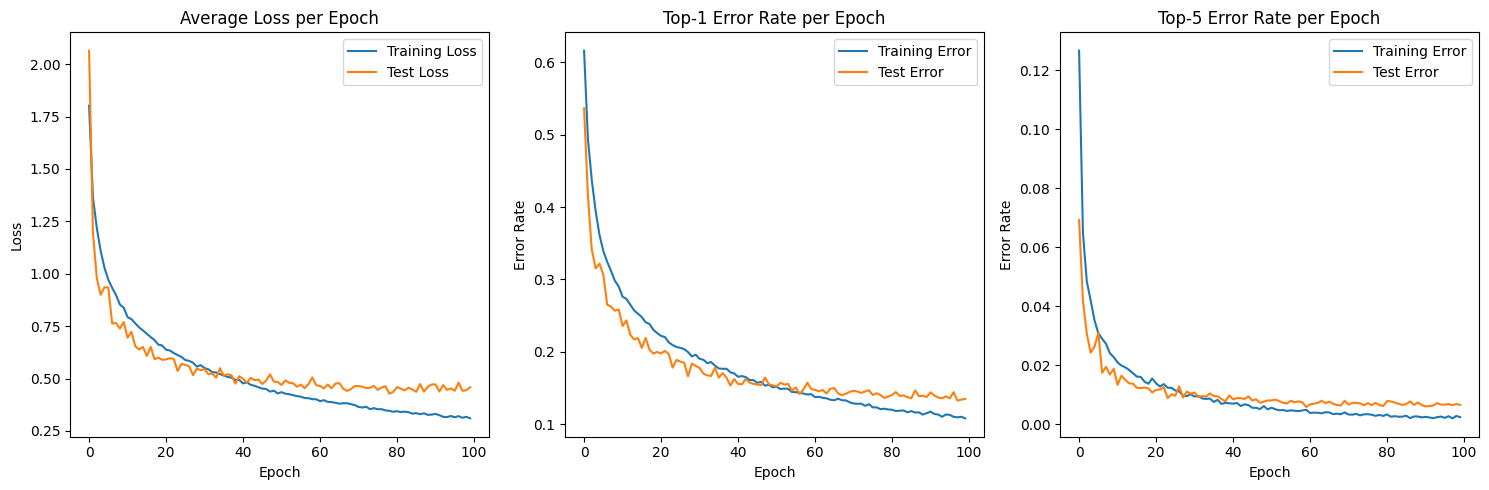

In [ ]:
# Plots
plt.figure(figsize=(15, 5))

# Plot average loss
plt.subplot(1, 3, 1)
plt.plot(history_l3.history['loss'], label='Training Loss')
plt.plot(history_l3.history['val_loss'],label='Test Loss')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot top-1 error rate
plt.subplot(1, 3, 2)
plt.plot(1 - np.array(history_l3.history['accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l3.history['val_accuracy']), label='Test Error')
plt.title('Top-1 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

# Plot top-5 error rate
plt.subplot(1, 3, 3)
plt.plot(1 - np.array(history_l3.history['top5_accuracy']), label='Training Error')
plt.plot(1 - np.array(history_l3.history['val_top5_accuracy']), label='Test Error')
plt.title('Top-5 Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.tight_layout()
plt.show()

It is evident that the majority of overfitting has been eliminated, as the training and test curves are now very close together across all three plots. This is a significant improvement over both Model 1 and Model 2. Model 3 achieves the best test performance of all models, with both the top-1 and top-5 test errors decreasing steadily and stabilizing around 0.13 and 0.01, respectively. The test loss also consistently decreases and remains stable. Therefore, Model 3 exhibits the best balance between optimization and generalization, with minimal overfitting and the lowest test errors.





# Part 3: Adversarial Robustness

This task aims to explore how models perform when subjected to adversarial attacks. Adversarial test accuracy will be used to evaluate robustness. The goal is to modify the training process to improve robustness and produce a model that achieves improved adversarial accuracy.

In [ ]:
# Function for PGD attack implementation.
def pgd_attack(loss_function, model, input, eps, data_std, data_min, data_max,
               n_steps=8, step_size=0.25, training=False):
    # apply normalised epsilon to the input data, making sure we're never crossing the data boundaries
    norm_eps = tf.reshape(eps / data_std, (1, 1, 1, -1))
    input_lb = tf.maximum(input - norm_eps, data_min)
    input_ub = tf.minimum(input + norm_eps, data_max)

    # PGD starts from a random initialiser
    step_size_scaling = (input_ub - input_lb) / 2
    adv_input = tf.Variable(tf.random.uniform(input_lb.shape) * (input_ub - input_lb) + input_lb)

    attack_point = input_lb
    attack_loss = (-np.inf) * tf.ones(input_lb.shape[0], dtype=tf.dtypes.float32)

    # attack loop
    for i in range(n_steps):
        with tf.GradientTape() as gtape:
            adv_outs = model(adv_input, training=training)
            obj = loss_function(adv_outs)
            obj_sum = tf.math.reduce_sum(obj)
        grad = gtape.gradient(obj_sum, adv_input)

        # keep the best attack point so far
        attack_point = tf.where(
            tf.reshape((obj >= attack_loss), (-1,) + (1,) * (int(tf.rank(input_lb) - 1))), x=adv_input, y=attack_point)
        attack_loss = tf.where(obj >= attack_loss, x=obj, y=attack_loss)

        adv_input = adv_input + step_size * step_size_scaling * tf.sign(grad)
        adv_input = tf.Variable(tf.maximum(tf.minimum(adv_input, input_ub), input_lb))

    adv_outs = model(adv_input, training=training)
    obj = loss_function(adv_outs)
    attack_point = tf.where(tf.reshape((obj >= attack_loss), (-1,) + (1,) * (int(tf.rank(input_lb) - 1))),
                            x=adv_input, y=attack_point)

    return attack_point

### Robustness of Model 3

In [ ]:
# Function that computes standard and adversarial test accuracy on the evaluation dataset.
def custom_eval(eval_dataset, model, eps=8/255, n_steps=8, step_size=0.25):
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    adv_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    for x, y in eval_dataset:
      # Standard accuracy (no attacks)
      val_logits = model(x, training=False)       # Evaluate model
      val_acc_metric.update_state(y, val_logits)  # Update metrics

      # Adversarial accuracy
      loss = lambda logits: keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(y, logits)
      # Generate adversarial examples
      adv_x = pgd_attack(loss_function=loss, model=model, input=x, eps=eps, n_steps=n_steps, step_size=step_size,
                         data_std=eval_dataset.std, data_min=eval_dataset.data_min, data_max=eval_dataset.data_max)
      adv_logits = model(adv_x, training=False)   # Evaluate model on adversarial examples
      adv_acc_metric.update_state(y, adv_logits)  # Update adv metrics

    val_acc = float(val_acc_metric.result())
    adv_acc = float(adv_acc_metric.result())

    print(f"Standard accuracy: {float(val_acc):.4f}")
    print(f"Adversarial accuracy: {float(adv_acc):.4f}")
    return val_acc, adv_acc

In [ ]:
# Evaluate Model 3
custom_eval(test_dataset, model_l3, eps=8/255)

Standard accuracy: 0.8652
Adversarial accuracy: 0.0061


(0.8651999831199646, 0.006099999882280827)

The results illustrate that Model 3 performs well on clean test data and is able to classify 86.5% of the test images correctly. However, the adversarial accuracy of 0.6% indicates that the model is very liable to adversarial attacks and misclassification occurs on almost all test images.


### Varying Perturbation Radius and Attack Parameters

To investigate which factors influence model robustness, the perturbation radius (eps), number of steps (n_steps) and step size (step_size) is varied to assess their impact on adversarial accuracy.


In [ ]:
# Loops to investigate varying parameters
results = []

# Vary eps
for eps in [2/255, 4/255, 8/255, 16/255]:
    val_acc, adv_acc = custom_eval(test_dataset, model_l3, eps=eps)
    results.append({"eps": eps, "n_steps": 8, "step_size": 0.25, "adv_acc": adv_acc})

# Vary n_steps
for n_steps in [4, 8, 20, 50]:
    val_acc, adv_acc = custom_eval(test_dataset, model_l3, n_steps=n_steps)
    results.append({"eps": 8/255, "n_steps": n_steps, "step_size": 0.25, "adv_acc": adv_acc})

# Vary step_size
for step_size in [0.05, 0.1, 0.25, 0.5]:
    val_acc, adv_acc = custom_eval(test_dataset, model_l3, step_size=step_size)
    results.append({"eps": 8/255, "n_steps": 8, "step_size": step_size, "adv_acc": adv_acc})

results_table = pd.DataFrame(results)
results_table

Standard accuracy: 0.8652
Adversarial accuracy: 0.4238
Standard accuracy: 0.8652
Adversarial accuracy: 0.1252
Standard accuracy: 0.8652
Adversarial accuracy: 0.0060
Standard accuracy: 0.8652
Adversarial accuracy: 0.0001
Standard accuracy: 0.8652
Adversarial accuracy: 0.0486
Standard accuracy: 0.8652
Adversarial accuracy: 0.0058
Standard accuracy: 0.8652
Adversarial accuracy: 0.0007
Standard accuracy: 0.8652
Adversarial accuracy: 0.0004
Standard accuracy: 0.8652
Adversarial accuracy: 0.2699
Standard accuracy: 0.8652
Adversarial accuracy: 0.0705
Standard accuracy: 0.8652
Adversarial accuracy: 0.0059
Standard accuracy: 0.8652
Adversarial accuracy: 0.0019


,eps,n_steps,step_size,adv_acc
0,0.007843,8,0.25,0.4238
1,0.015686,8,0.25,0.1252
2,0.031373,8,0.25,0.0060
3,0.062745,8,0.25,0.0001
4,0.031373,4,0.25,0.0486
5,0.031373,8,0.25,0.0058
6,0.031373,20,0.25,0.0007
7,0.031373,50,0.25,0.0004
8,0.031373,8,0.05,0.2699
9,0.031373,8,0.10,0.0705


The results demonstrate that as the perturbation radius increases, adversarial accuracy decreases significantly. When eps = $\frac{2}{255}$, the adversarial accuracy is 42.4%, while at eps = $\frac{16}{255}$ an approximately 0% accuracy is achieved. This implies that higher perturbation radius leads to stronger attacks, limiting the model's ability to accurately classify images.

The number of steps also plays an important role in adversarial accuracy, as increasing n_steps results in a decrease in adversarial accuracy. This suggests that more steps leave the model more vulnerable to attacks.

As shown in the table, smaller step sizes produce higher adversarial accuracy. Significant improvement in accuracy can be seen between step_size = 0.05 with an accuracy of 0.27 and step_size = 0.1 with an accuracy of 0.07.

In conclusion, the table confirms that increasing the perturbation radius and the number of steps causes adversarial accuracy to drop significantly, ultimately driving it to zero. Increasing the perturbation radius strengthens the attacks and larger PGD steps allow the attack to find optimal perturbations.


### Sensitivity of Adversarial Accuracy to Model Parameters and Architecture

To determine whether standard improvements in accuracy also enhance robustness, different architectural and training hyperparameters choices are assess.


In [ ]:
# Model with more filters
model_filters = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomTranslation(0.1, 0.1),
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])
# Compile model
model_filters.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy())
# Train model
history_filters = model_filters.fit(train_dataset, epochs=30, validation_data=test_dataset, verbose=1)

# Model with higher learning rate
model_high_lr = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomTranslation(0.1, 0.1),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])
# Compile model
model_high_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.SparseCategoricalCrossentropy())
# Train model
history_high_lr = model_high_lr.fit(train_dataset, epochs=30, validation_data=test_dataset, verbose=1)

# Model with lower learning rate
model_low_lr = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomTranslation(0.1, 0.1),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])
# Compile model
model_low_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy())
# Train model
history_low_lr = model_low_lr.fit(train_dataset, epochs=30, validation_data=test_dataset, verbose=1)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 2.7401 - val_loss: 1.7887
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 1.4488 - val_loss: 1.3132
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 1.2399 - val_loss: 1.0040
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 1.1253 - val_loss: 0.8816
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 1.0281 - val_loss: 1.0544
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.9625 - val_loss: 0.9142
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.9100 - val_loss: 0.8207
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 0.8600 - val_loss: 0.8230
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.8230 - val_loss: 0.7238
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.7768 - val_loss: 0.7065
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.7509 - val_loss: 0.6610
Epoch 12/30
313/313 ━━━━━━━━━━

In [ ]:
# Investigate adversarial robustness with all altered models
for name, model in [("Model 1: Baseline", model_l1),
                    ("Model 2: Batch Normalization", model_l2),
                    ("Model 3: Data Augmentation", model_l3),
                    ("Model with More Filters", model_filters),
                    ("Model with a Higher Learning Rate", model_high_lr),
                    ("Model with a Lower Learning Rate", model_low_lr)]:
    print(f"\n-- {name} --")
    custom_eval(test_dataset, model, eps=8/255)


-- Model 1: Baseline --
Standard accuracy: 0.7463
Adversarial accuracy: 0.0453

-- Model 2: Batch Normalization --
Standard accuracy: 0.8313
Adversarial accuracy: 0.0137

-- Model 3: Data Augmentation --
Standard accuracy: 0.8652
Adversarial accuracy: 0.0063

-- Model with More Filters --
Standard accuracy: 0.8279
Adversarial accuracy: 0.0790

-- Model with a Higher Learning Rate --
Standard accuracy: 0.7251
Adversarial accuracy: 0.0488

-- Model with a Lower Learning Rate --
Standard accuracy: 0.7577
Adversarial accuracy: 0.0041


Although different features improve standard accuracy, no method significantly enhance adversarial robustness. All models yield an adversarial accuracy below 0.08, despite standard accuracy ranging from 0.73 to 0.87.

Taking a closer look, Model 3 achieves the highest standard accuracy (0.87) but also the lowest adversarial accuracy (0.0063). In contrast, the model with a higher learning rate achieves the lowest standard accuracy (0.73) but a higher adversarial accuracy (0.05). Additionally, both batch normalization and data augmentation improve standard accuracy, but surprisingly, they reduce adversarial accuracy. This suggests that better standard accuracy does not imply better adversarial accuracy.

Among the models, more filters appears to have the most positive effect on adversarial accuracy, yet the improvement is still not significant with adversarial robustness being 0.08. Furthermore, changes in learning rate show no difference in adversarial accuracy.

Overall, it is quite clear that standard architectural adjustments and training hyperparameters improvements do not reduce a model's vulnerability to PGD attacks. This suggests that different training approaches may be needed to improve adversarial robustness.


### Improved Network

Following the evaluation above, the training process is designed to improve robustness against adversarial attacks.

In [ ]:
# Training loop
def custom_train(train_dataset, val_dataset, model, lr=1e-3, wd=1e-3, epochs=30, val_freq=1, eps=8/255, n_steps=8, step_size=0.25):
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(learning_rate=lr, weight_decay=wd)
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    for epoch in range(epochs):
        # Iterate over the batches of a dataset.
        for x, y in train_dataset:

            # Adversarial accuracy
            adv_loss = lambda logits: keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(y, logits)
            # Generate adversarial examples
            adv_x = pgd_attack(loss_function=adv_loss, model=model, input=x, eps=eps, n_steps=n_steps, step_size=step_size,
                         data_std=train_dataset.std, data_min=train_dataset.data_min, data_max=train_dataset.data_max)

            # Train on adversarial examples
            with tf.GradientTape() as tape:
                # Forward pass.
                logits = model(adv_x)
                # Loss value for this batch.
                loss_value = loss_fn(y, logits)
                # Add extra loss terms to the loss value.
                loss_value += sum(model.losses)

            # Update the weights of the model to minimize the loss value.
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            train_acc_metric.update_state(y, logits)

        train_acc = train_acc_metric.result()
        train_acc_metric.reset_state()
        print(f"Training Accuracy: {float(train_acc):.4f}")

        if (epoch + 1) % val_freq == 0:
            custom_eval(val_dataset, model)

In [ ]:
# Build Model 3 again with the exact same architecture (from P2). Train the model from stratch using the improve training process.
model_l3_adv = tf.keras.Sequential([
tf.keras.layers.Input(shape=(32,32,3)),
tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomTranslation(0.1, 0.1),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(10, activation='softmax')])

# Train with adversarial training
custom_train(train_dataset, test_dataset, model_l3_adv, epochs=30, eps=8/255)

# Evaluate models
standard_training = custom_eval(test_dataset, model_l3, eps=8/255)
adv_training = custom_eval(test_dataset, model_l3_adv, eps=8/255)

# Print results (test accuracy)
print(f"Standard Model 3: {standard_training}")
print(f"Adversarial Trained Model 3: {adv_training}")

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Training Accuracy: 0.3050
Standard accuracy: 0.4866
Adversarial accuracy: 0.1634
Training Accuracy: 0.3523
Standard accuracy: 0.5309
Adversarial accuracy: 0.1678
Training Accuracy: 0.3756
Standard accuracy: 0.5605
Adversarial accuracy: 0.1912
Training Accuracy: 0.3898
Standard accuracy: 0.5753
Adversarial accuracy: 0.1819
Training Accuracy: 0.4053
Standard accuracy: 0.6011
Adversarial accuracy: 0.1928
Training Accuracy: 0.4252
Standard accuracy: 0.6154
Adversarial accuracy: 0.1916
Training Accuracy: 0.4325
Standard accuracy: 0.6187
Adversarial accuracy: 0.2096
Training Accuracy: 0.4478
Standard accuracy: 0.6257
Adversarial accuracy: 0.1892
Training Accuracy: 0.4533
Standard accuracy: 0.6425
Adversarial accuracy: 0.1919
Training Accuracy: 0.4655
Standard accuracy: 0.6460
Adversarial accuracy: 0.1919
Training Accuracy: 0.4700
Standard accuracy: 0.6513
Adversarial accuracy: 0.2001
Training Accuracy: 0.4802
Standard accuracy: 0.6563
Adversarial accuracy: 0.1925
Training Accuracy: 0.4834
St

After adjusting the training process to account for adversarial training, the model's adversarial accuracy improves significantly to 16.3% (from 0.65%), illustrating that adversarial training can improve the robustness of models. However, it is also important to note that more robust models lead to decreases in the standard accuracy (fell from 86.5% to 70.19%). This highlights the trade-off between improving adversarial robustness and maintaining high performance on clean data.

To reduce this trade-off, adversarial attacks can be made stronger by increasing the number of steps and the perturbation radius. This will enhance adversarial training because the model will learn more robust features from the stronger attacks, resulting in higher test accuracy.

(Unfortunately, these improved results cannot be shown as I ran out of GPU runtime and RAM).

